In [129]:
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sb
from analyze_experiment_in_progress import get_data_from_logs
sb.set()

In [148]:
#bert4rec outperforms everything
#experiment_logs = './results/bert4rec_config_2021_11_04T17_15_31/stdout'

#SALREC-BCE-Great
#experiment_logs = './results/bert4rec_config_2021_11_07T22_26_10/stdout'


#SALREC-Lambdarank 0.157107
#experiment_logs = './results/ml_benchmark20m_2021_11_18T16_38_37/stdout'



#Transformer-Lambdarank 0.1603
#experiment_logs = './results/ml_benchmark20m_2021_11_19T17_43_30/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_23T14_39_04/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_25T09_41_35/stdout'

#Fast Lambdarank on dekstop
#experiment_logs = './results/ml_benchmark20m_2021_11_27T23_55_22/stdout'


#Fast Lambdarank on dekstop - 40k, bce slightly better
#experiment_logs = './results/ml_benchmark20m_2021_11_28T08_36_11/stdout'


# Learning rate effects:

# Lambdarank
#experiment_logs = "./results/ml_benchmark20m_2021_11_26T10_36_55/stdout"
#BCE
experiment_logs = "./results/ml_benchmark20m_2021_11_27T11_36_03/stdout"



#Truncation effects: 
#1-20
#experiment_logs = "./results/ml_benchmark20m_2021_11_28T18_14_50/stdout"

#30-120
#experiment_logs = "./results/ml_benchmark20m_2021_11_29T15_12_00/stdout"

In [149]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [150]:
data = get_data_from_logs(experiment_logs, 0)

In [151]:
df = pd.DataFrame(data).set_index('model_name')
df

,ndcg@40,precision@5,recall@5,SPS@10,MRR,MAP@10,apr@10,pairwise_cos_sim@10,model_build_time,model_inference_time,model_metadata,num_epochs,metrics_history
model_name,,,,,,,,,,,,,
Transformer-BCE-blocks:3-lr:0.005,0.111306,0.01785,0.08925,0.14000,0.066642,0.054329,606.307075,0.110451,14425.330768,155.844782,"{'epochs_trained': 192, 'best_val_ndcg': 0.09077351540327072, 'val_ndcg_history': [[70.2834575176239, 0.021948665380477905], [146.30579447746277, 0.01738707907497883], [221.09597373008728, 0.027255777269601822], [296.1847836971283, 0.020583588629961014...",192,"[{'loss': 0.0032, 'ndcg_at_40': 0.0555, 'val_loss': 0.001, 'val_ndcg_at_40': 0.0219, 'epoch': 1, 'val_ndcg': 0.021948665380477905, 'best_ndcg': 0.021948665380477905, 'steps_since_improved': 0.0, 'total_training_time': 70.2834575176239}, {'loss': 0.0061..."
Transformer-BCE-blocks:3-lr:0.002,0.131455,0.02125,0.10625,0.16625,0.080249,0.066747,795.555750,0.096703,14454.372747,155.374379,"{'epochs_trained': 173, 'best_val_ndcg': 0.11232790350914001, 'val_ndcg_history': [[71.03625440597534, 0.022835947573184967], [147.1691517829895, 0.023948779329657555], [223.85024738311768, 0.02414972521364689], [301.24034428596497, 0.02129525691270828...",189,"[{'loss': 0.0061, 'ndcg_at_40': 0.0521, 'val_loss': 0.001, 'val_ndcg_at_40': 0.0228, 'epoch': 1, 'val_ndcg': 0.022835947573184967, 'best_ndcg': 0.022835947573184967, 'steps_since_improved': 0.0, 'total_training_time': 71.03625440597534}, {'loss': 9.544..."
Transformer-BCE-blocks:3-lr:0.001,0.149793,0.02410,0.12050,0.18650,0.092764,0.078417,832.149900,0.090737,14475.932717,157.455010,"{'epochs_trained': 180, 'best_val_ndcg': 0.13134151697158813, 'val_ndcg_history': [[67.66087508201599, 0.027505777776241302], [144.08619141578674, 0.02049311064183712], [219.84385108947754, 0.036239899694919586], [295.6279125213623, 0.03338269889354706...",191,"[{'loss': 0.0071, 'ndcg_at_40': 0.0559, 'val_loss': 0.001, 'val_ndcg_at_40': 0.0275, 'epoch': 1, 'val_ndcg': 0.027505777776241302, 'best_ndcg': 0.027505777776241302, 'steps_since_improved': 0.0, 'total_training_time': 67.66087508201599}, {'loss': 9.512..."
Transformer-BCE-blocks:3-lr:0.0005,0.149371,0.02435,0.12175,0.18750,0.092132,0.077937,875.586725,0.091105,14435.177793,158.201163,"{'epochs_trained': 176, 'best_val_ndcg': 0.12837165594100952, 'val_ndcg_history': [[68.62609910964966, 0.021336965262889862], [145.81687927246094, 0.028330300003290176], [221.92511081695557, 0.030035369098186493], [298.4106454849243, 0.0277368929237127...",190,"[{'loss': 0.0111, 'ndcg_at_40': 0.0562, 'val_loss': 0.001, 'val_ndcg_at_40': 0.0213, 'epoch': 1, 'val_ndcg': 0.021336965262889862, 'best_ndcg': 0.021336965262889862, 'steps_since_improved': 0.0, 'total_training_time': 68.62609910964966}, {'loss': 9.399..."
Transformer-BCE-blocks:3-lr:0.0002,0.111538,0.01670,0.08350,0.13425,0.067411,0.054561,710.847100,0.100251,14465.563792,159.922564,"{'epochs_trained': 161, 'best_val_ndcg': 0.09356529265642166, 'val_ndcg_history': [[67.90508484840393, 0.028129875659942627], [144.89305925369263, 0.024253113195300102], [221.10758709907532, 0.021459084004163742], [297.40004658699036, 0.021183252334594...",190,"[{'loss': 0.0204, 'ndcg_at_40': 0.0586, 'val_loss': 0.001, 'val_ndcg_at_40': 0.0281, 'epoch': 1, 'val_ndcg': 0.028129875659942627, 'best_ndcg': 0.028129875659942627, 'steps_since_improved': 0.0, 'total_training_time': 67.90508484840393}, {'loss': 9.412..."
Transformer-BCE-blocks:3-lr:0.0001,0.108498,0.01625,0.08125,0.12950,0.065307,0.052706,699.376450,0.102008,14469.669937,160.074541,"{'epochs_trained': 186, 'best_val_ndcg': 0.08648058772087097, 'val_ndcg_history': [[67.74561285972595, 0.022139042615890503], [145.38441348075867, 0.022381067276000977], [221.67512440681458, 0.022618873044848442], [298.7602241039276, 0.0238425731658935...",189,"[{'loss': 0.0331, 'ndcg_at_40': 0.0571, 'val_loss': 0.001, 'val_ndcg_at_40': 0.0221, 'epoch': 1, 'val_ndcg': 0.022139042615890503, 'best_ndcg': 0.022139042615890503, 'steps_since_im

No handles with labels found to put in legend.


<Figure size 1152x648 with 0 Axes>

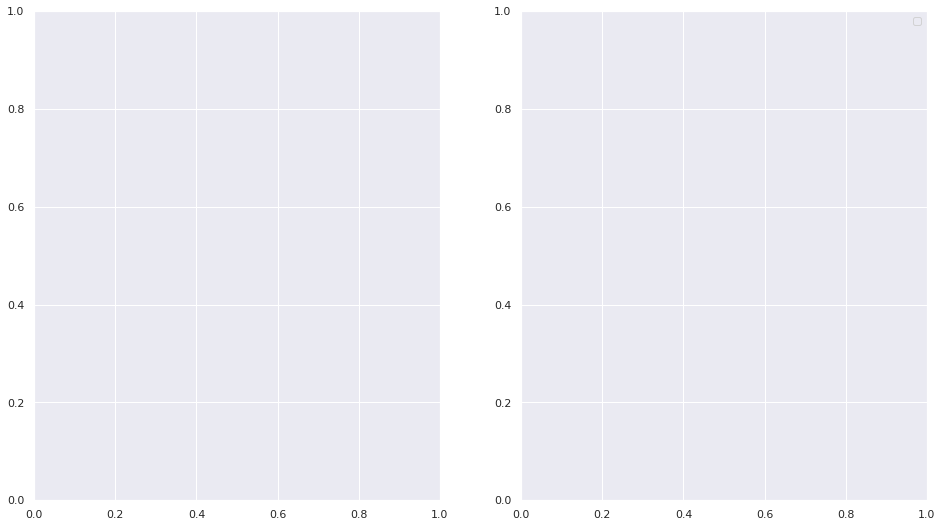

In [152]:
moving_average_steps=1
max_points = 30000


def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(16, 9))

axises = ['epoch', 'total_training_time']

fig, ax = plt.subplots(1, len(axises))
fig.set_figheight(9)
fig.set_figwidth(16)

interesting_models = ['Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50']
second_metrics = {}

for recommender in data:
    if recommender['model_name'] not in interesting_models:
        continue
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        metric_name = 'val_ndcg'
        second_metric_name = 'ndcg_at_50'
        metric = moving_average(get_metric(history, metric_name), moving_average_steps)[:max_points]
        if second_metric_name != None:
            second_metric = moving_average(get_metric(history, second_metric_name), moving_average_steps)[:max_points]
        #success = get_metric(history, 'Success_at_4')
        #val_success = moving_average(get_metric(history, 'val_Success_at_4'), 5)
        
        #plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        for axis_num in range(len(axises)):
            axis_name = axises[axis_num]
            axis = get_metric(history, axis_name)[moving_average_steps - 1:][:max_points]
            ax[axis_num].plot(axis, metric,label=recommender['model_name'])
            
            ax[axis_num].set_xlabel(axis_name)
            if axis_num == 0:
                ax[axis_num].set_ylabel(metric_name)
            
            if (second_metric_name != None):
                if axis_num not in second_metrics:
                    second_metrics[axis_num] = ax[axis_num].twinx()
                    print(axis_num, second_metrics.keys())
                ax2 = second_metrics[axis_num]
                if axis_num == 1:
                    ax2.set_ylabel(second_metric_name)
                ax2.plot(axis, second_metric, '--', label=recommender['model_name'],)

            
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


In [147]:
len(metric), len(metric) - np.argmax(metric) - 1

(108, 12)

In [136]:
max(metric)

0.12517809867858887